In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
import pandas as pd
from joblib import Parallel, delayed
import itertools
import matplotlib.pyplot as plt

# --- 1. Define the Fast RHS with Numba ---
# We pass the grids as arguments so Numba can access them efficiently
@njit
def tov_rhs_fast(r, x, grid_p_q, grid_e_q, grid_p_dm, grid_e_dm):
    p1, M1, p2, M2 = x
    
    # Sanitize
    p1 = max(0.0, p1)
    p2 = max(0.0, p2)
    
    # 1. Get Energy Densities (Interpolation inside Numba is very fast)
    if p1 > 0:
        e1 = np.interp(p1, grid_p_q, grid_e_q)
    else:
        e1 = 0.0
        
    if p2 > 0:
        e2 = np.interp(p2, grid_p_dm, grid_e_dm)
    else:
        e2 = 0.0
    
    M = M1 + M2
    
    # 2. Singularity / Center check
    if r < 1e-9:
        return np.array([0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2])
    
    # 3. Metric Terms
    term3 = 1.0 - 2.0 * M / r
    
    # Horizon check (to avoid division by zero)
    if term3 <= 1e-9:
        return np.array([0.0, 0.0, 0.0, 0.0])
    
    factor = - (M / r**2) / term3
    term2_part = 4 * np.pi * r**3 * (p1 + p2) / M if M > 0 else 0.0
    term2 = 1.0 + term2_part
    
    # 4. Derivatives
    # Fluid 1 (Quark)
    if p1 <= 0:
        dp1dr = 0.0
        dM1dr = 0.0
    else:
        dp1dr = factor * (e1 + p1) * term2
        dM1dr = 4 * np.pi * r**2 * e1
        
    # Fluid 2 (DM)
    if p2 <= 0:
        dp2dr = 0.0
        dM2dr = 0.0
    else:
        dp2dr = factor * (e2 + p2) * term2
        dM2dr = 4 * np.pi * r**2 * e2
        
    return np.array([dp1dr, dM1dr, dp2dr, dM2dr])

# --- 2. The Compute Function ---

def compute_star_properties(params, grid_p_q, grid_e_q, grid_p_dm, grid_e_dm):
    # Unpack parameters
    e_q_c, p_q_c, e_dm_c, p_dm_c = params
    r0 = 1e-6
    
    # Initial Conditions
    m_q_c = (4.0/3.0) * np.pi * r0**3 * e_q_c
    m_dm_c = (4.0/3.0) * np.pi * r0**3 * e_dm_c
    x0 = [p_q_c, m_q_c, p_dm_c, m_dm_c]
    
    # --- CORRECTED EVENT FUNCTION ---
    # We add *args here so it accepts the grids passed by solve_ivp without crashing
    def event_surface(r, x, *args):
        # Trigger when the higher of the two pressures drops below threshold
        return max(x[0], x[2]) - 1e-15 

    event_surface.terminal = True
    event_surface.direction = -1
    
    # Solve
    sol = solve_ivp(
        tov_rhs_fast, 
        (r0, 1e5),
        x0,
        args=(grid_p_q, grid_e_q, grid_p_dm, grid_e_dm), # These get passed to event_surface too!
        events=event_surface,
        rtol=1e-6, atol=1e-8,
        method='RK45' 
    )
    
    # Extract Results
    r = sol.t
    p1 = sol.y[0]
    m1 = sol.y[1]
    p2 = sol.y[2]
    m2 = sol.y[3]
    
    # Find radii (last index where pressure > 0)
    q_mask = p1 > 0
    dm_mask = p2 > 0
    
    R_q = r[q_mask][-1] if np.any(q_mask) else 0.0
    M_q = m1[q_mask][-1] if np.any(q_mask) else 0.0
    
    R_dm = r[dm_mask][-1] if np.any(dm_mask) else 0.0
    M_dm = m2[dm_mask][-1] if np.any(dm_mask) else 0.0
    
    return {
        "Central E Quark": e_q_c,
        "Central E DM": e_dm_c,
        "R_total": max(R_q, R_dm),
        "M_total": M_q + M_dm,
        "R_quark": R_q,
        "M_quark": M_q,
        "R_dm": R_dm,
        "M_dm": M_dm
    }

In [2]:
#open csv file
eos_df = pd.read_csv("../Data/EOS_MIT_Massless_quarks.csv")
grid_e_quark = eos_df["Energy Density"].values
grid_p_quark = eos_df["Pressure"].values
eos_df_DM = pd.read_csv("../Data/EOS_Bosonic_DM_n4.csv")
grid_e_DM = eos_df_DM["Energy Density"].values
grid_p_DM = eos_df_DM["Pressure"].values


In [3]:
e_surface_quark = grid_e_quark[0] # grid_p_quark[0] is the zero-pressure point

minimum_e_quark = e_surface_quark * (1 + 1e-20) 
maximum_e_quark = grid_e_quark[-1]

list_e_central_conditions_quark = np.logspace(
    np.log10(minimum_e_quark), 
    np.log10(maximum_e_quark), 
    num=1000
)


list_p_central_conditions_quark = np.interp(
    list_e_central_conditions_quark, 
    grid_e_quark, 
    grid_p_quark
)

list_e_central_conditions_DM = np.logspace(-5, 5,10)
list_p_central_conditions_DM = np.interp(
        list_e_central_conditions_DM,
        grid_e_DM,
        grid_p_DM
    )




In [4]:

quark_pairs = list(zip(list_e_central_conditions_quark, list_p_central_conditions_quark))

dm_pairs = list(zip(list_e_central_conditions_DM, list_p_central_conditions_DM))

combined_product = list(itertools.product(quark_pairs, dm_pairs))

param_list = [
    (q[0], q[1], dm[0], dm[1]) 
    for q, dm in combined_product
]

# 5. Run in Parallel (same as before)
results_list = Parallel(n_jobs=-1)(
    delayed(compute_star_properties)(
        p, grid_p_quark, grid_e_quark, grid_p_DM, grid_e_DM
    ) for p in param_list
)

results_df = pd.DataFrame(results_list)

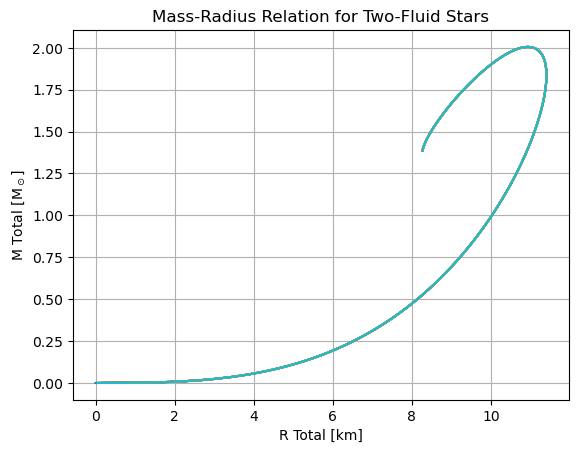

In [8]:
# create different df for each value of e_dm
B = 145**4
hc = 197.3269804 # MeV fm

M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B
subset_dict = {}
for e_dm in list_e_central_conditions_DM:
    name = str(e_dm)
    df_subset = results_df[results_df["Central E DM"] == e_dm].copy()
    #compute pressure interplolation for each value of e_dm
    df_subset["P_DM"] = np.interp( df_subset["Central E DM"].values, grid_e_DM, grid_p_DM) * (4 * B / (hc**3))

    #df_subset["P_DM"] = np.interp(df_subset["Central E DM"], grid_e_DM, grid_p_DM) * 4 * B / (hc**3)
    plt.plot(df_subset["R_total"] * factor_R_to_km, df_subset["M_total"] * factor_M_to_Solar)
    subset_dict[name] = df_subset

plt.xlabel("R Total [km]")
plt.ylabel("M Total [M$_\odot$]")
plt.title("Mass-Radius Relation for Two-Fluid Stars")
plt.grid()
plt.show()





In [7]:
list_e_central_conditions_DM

array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])

In [9]:
def compute_two_fluid_properties_fast(
    e_q_c, p_q_c, e_dm_c, p_dm_c,
    grid_p_q, grid_e_q, grid_p_dm, grid_e_dm,
    r0=1e-6, r_max=1e12
):

    # Initial masses
    m_q_c  = (4/3) * np.pi * r0**3 * e_q_c
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm_c
    x0 = [p_q_c, m_q_c, p_dm_c, m_dm_c]

    def rhs(r, x):
        p1, M1, p2, M2 = x
        p1 = max(p1, 0.0)
        p2 = max(p2, 0.0)

        e1 = np.interp(p1, grid_p_q,  grid_e_q)  if p1 > 0 else 0.0
        e2 = np.interp(p2, grid_p_dm, grid_e_dm) if p2 > 0 else 0.0

        M = M1 + M2
        if r < 1e-9 or M <= 0:
            return [0.0, 4*np.pi*r**2*e1, 0.0, 4*np.pi*r**2*e2]

        term3 = 1.0 - 2.0*M/r
        if term3 <= 1e-10:
            return [0.0, 0.0, 0.0, 0.0]

        factor = -(M / r**2) / term3
        term2 = 1.0 + 4*np.pi*r**3*(p1+p2)/M

        dp1 = factor * (e1 + p1) * term2 if p1 > 0 else 0.0
        dp2 = factor * (e2 + p2) * term2 if p2 > 0 else 0.0

        return [
            dp1,
            4*np.pi*r**2*e1 if p1 > 0 else 0.0,
            dp2,
            4*np.pi*r**2*e2 if p2 > 0 else 0.0
        ]

    # --- EVENTS ---
    def event_quark_surface(r, x):
        return x[0]
    event_quark_surface.terminal = True
    event_quark_surface.direction = -1

    def event_dm_surface(r, x):
        return x[2]
    event_dm_surface.terminal = False
    event_dm_surface.direction = -1

    sol = solve_ivp(
        rhs,
        (r0, r_max),
        x0,
        events=[event_dm_surface, event_quark_surface],
        rtol=1e-7,
        atol=1e-9
    )

    r = sol.t
    p1, m1, p2, m2 = sol.y

    q_mask  = p1 > 0
    dm_mask = p2 > 0

    R_q  = r[q_mask][-1]  if np.any(q_mask)  else 0.0
    M_q  = m1[q_mask][-1] if np.any(q_mask)  else 0.0
    R_dm = r[dm_mask][-1] if np.any(dm_mask) else 0.0
    M_dm = m2[dm_mask][-1]if np.any(dm_mask) else 0.0

    return {
        "R_quark": R_q,
        "M_quark": M_q,
        "R_dm": R_dm,
        "M_dm": M_dm,
        "R_total": max(R_q, R_dm),
        "M_total": M_q + M_dm
    }
